In [1]:
import os
import sys
import argparse

MAIN_PATH = os.path.abspath(os.path.join('../src'))
sys.path.append(MAIN_PATH)

import numpy as np
import pandas as pd
import torch

import proloaf.datahandler as dh
import proloaf.modelhandler as mh
import proloaf.baselinehandler as baselines
from proloaf.tensorloader import TimeSeriesData
import proloaf.plot as plot

from proloaf.confighandler import read_config
from proloaf.cli import parse_with_loss
from proloaf import metrics
from proloaf.event_logging import create_event_logger

logger = create_event_logger('baselines')

2022-03-25 18:00:28 - event_logging - WARNING - Logger name "proloaf.baselinehandler" could not be found in the logging config. Default logger was created


In [2]:
config_path = 'opsd'
PAR = read_config(config_path, main_path="../")
model_name = PAR["model_name"]
data_path = PAR["data_path"]

INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

SCALE_DATA = True
LIMIT_HISTORY = PAR["history_horizon"]
SLIDING_WINDOW = 1
DAY_FIRST = True
ORDER = (3, 1, 0)
sORDER = (2, 0, 0, 24)
SEASONALITY=24
PERIODICITY=7
ALPHA = 1.96
EXOG = True
APPLY_EXISTING_MODEL = False
RESOLUTION = 'H'

arima_order = ORDER
sarima_order = ORDER
sarima_sorder = sORDER

DEVICE = "cpu"

torch.set_printoptions(linewidth=120) # Display option for output
torch.set_grad_enabled(True)

In [3]:
PAR

{'data_path': './data/opsd.csv',
 'output_path': './oracles/',
 'exploration_path': './targets/opsd/tuning.json',
 'evaluation_path': './oracles/eval_opsd_recurrent/',
 'log_path': './logs/',
 'model_name': 'opsd_recurrent',
 'target_id': ['DE_load_actual_entsoe_transparency'],
 'target_list': None,
 'start_date': None,
 'history_horizon': 147,
 'forecast_horizon': 24,
 'cap_limit': 1,
 'train_split': 0.6,
 'validation_split': 0.8,
 'periodicity': 24,
 'optimizer_name': 'adam',
 'exploration': False,
 'cuda_id': None,
 'feature_groups': [{'name': 'main',
   'scaler': ['minmax', -1.0, 1.0],
   'features': ['AT_load_actual_entsoe_transparency',
    'DE_load_actual_entsoe_transparency',
    'AT_temperature',
    'AT_radiation_direct_horizontal',
    'AT_radiation_diffuse_horizontal',
    'DE_temperature',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal']},
  {'name': 'aux',
   'scaler': None,
   'features': ['hour_0',
    'hour_1',
    'hour_2',
    'hour_3',
  

### Read load data and set frequency and timestamps
We set the frequency of timesteps to hours. This frequency of the dataframe is e.g. used in the naive seasonal decomposition forecast model.

We take all features into consideration that have been categorized as either encoder or decoder feature. We will then only take those different from the endogeneous feature. So here we need to remove the target (=endogenous) feature.

In [4]:
df = pd.read_csv(INFILE, sep=';',index_col=0)
df = dh.fill_if_missing(df, periodicity=SEASONALITY)
df = dh.set_to_hours(df, freq=RESOLUTION)
df = df.asfreq(freq='H')

target = PAR['target_id']
enc_features = PAR['encoder_features']
dec_features = PAR['decoder_features']

#now just make sure that the exogenous features do not include the target itself as endog already does.
if target in enc_features: enc_features.remove(target)
if target in dec_features: dec_features.remove(target)

2022-03-25 18:00:29 - datahandler - INFO - No missing data


### Now the data shall be scaled and split according to the scalers and train-test split defined in the config

In [5]:
if SCALE_DATA:
    scaler = dh.MultiScaler(PAR["feature_groups"])
    df = scaler.fit_transform(df)

df_train, df_val = dh.split(df, splits=[PAR["validation_split"]])

Lets checkout which endog and exog features we are dealing with:

In [6]:
display(df_train)

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_sin,hour_cos,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,0.041917,-0.574240,-0.557967,-1.000000,-1.000000,-0.512260,-1.000000,-1.000000,-0.258819,9.659258e-01,...,0,0,1,0,0,1,0,0,0,0
2015-01-01 00:00:00,0.041917,-0.574240,-0.558285,-1.000000,-1.000000,-0.513962,-1.000000,-1.000000,0.000000,1.000000e+00,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 01:00:00,-0.001479,-0.618183,-0.556494,-1.000000,-1.000000,-0.516205,-1.000000,-1.000000,0.258819,9.659258e-01,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 02:00:00,-0.076240,-0.662688,-0.548331,-1.000000,-1.000000,-0.519277,-1.000000,-1.000000,0.500000,8.660254e-01,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 03:00:00,-0.095572,-0.677436,-0.534593,-1.000000,-1.000000,-0.521644,-1.000000,-1.000000,0.707107,7.071068e-01,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 14:00:00,0.317881,-0.130012,-0.263782,-0.991061,-0.825684,-0.252860,-0.998857,-0.895807,-0.500000,-8.660254e-01,...,0,0,1,1,0,0,0,0,0,0
2018-12-31 15:00:00,0.363448,-0.049479,-0.316623,-0.999958,-0.997092,-0.276446,-0.999967,-0.995226,-0.707107,-7.071068e-01,...,0,0,1,1,0,0,0,0,0,0
2018-12-31 16:00:00,0.413157,0.060594,-0.331395,-1.000000,-1.000000,-0.275324,-1.000000,-1.000000,-0.866025,-5.000000e-01,...,0,0,1,1,0,0,0,0,0,0


Here, in the later methods we currently do not use torch tensors. But we apply a similar tranform just as it is done, with with the ProLoaF Tensorloader, resulting in pandas dataframes for the input and output values on the train and validation set. Some of the baseline methods, only work with **numpy arrays** instead of dataframes. We create the datastructures for both purposes here:

In [7]:
dataset_train = TimeSeriesData(
    df_train,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["target_id"],
    decoder_features=None,
    target_id=PAR["target_id"],
)
dl_train = dataset_train.make_data_loader(batch_size=1, shuffle=False)
x_train_1D = np.array([input.squeeze().numpy() for input, _, _ in dl_train])
y_train_1D = np.array([target.squeeze().numpy() for _, _, target in dl_train])

2022-03-25 18:00:29 - tensorloader - DEBUG - frame not prepared


We seperately generate the dataloaders and numpy arrays for the validation data

In [8]:
dataset_val = TimeSeriesData(
    df_val,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["target_id"],
    decoder_features=None,
    target_id=PAR["target_id"],
)
dl_val = dataset_val.make_data_loader(batch_size=1, shuffle=False)
x_val_1D = np.array([input.squeeze().numpy() for input, _, _ in dl_val])
y_val_1D = np.array([target.squeeze().numpy() for _, _, target in dl_val])

2022-03-25 18:00:31 - tensorloader - DEBUG - frame not prepared


We want to fill step by step empty arrays with the expected values and prediction intervals (quantiles), computed from each of the following baseline models. The array baseline_method will contain the names of the computed methods, which will serve as labels lateron in the benchmark step.

In [9]:
mean_forecast = []
upper_PI = []
lower_PI = []
baseline_method = []

### We will generate exogenous variables already now for some of the baseline methods that make use of them.

In [10]:
df_exog_train = df_train[enc_features+dec_features]
df_exog_val = df_val[enc_features+dec_features]

### <u>Baseline model1</u>:   Naive Persistence model

In [11]:
naive_expected_values, naive_y_pred_upper, naive_y_pred_lower = baselines.persist_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], alpha=ALPHA)
mean_forecast.append(naive_expected_values)
upper_PI.append(naive_y_pred_upper)
lower_PI.append(naive_y_pred_lower)
baseline_method.append('simple-naive')

Train a naive (persistence) timeseries model...
Training and validating naive (persistence) model completed.


### <u>Baseline model2</u>: Seasonal Naive

* <u>**Major difference from the persistence model**</u>: Instead of forecasting last observed value for the entire horizon, it considers the <u>**previous day's value for each corresponding hour in the forecast horizon.**</u>
* Lets call it the periodic model. That is the default solution. By changing seasonality and periodicity the timeseries pattern that is underlying the data can be respected.

In [12]:
# SNaïve
s_naive_expected_values, s_naive_y_pred_upper, s_naive_y_pred_lower = baselines.seasonal_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'], PERIODICITY, alpha=ALPHA)
mean_forecast.append(s_naive_expected_values)
upper_PI.append(s_naive_y_pred_upper)
lower_PI.append(s_naive_y_pred_lower)
baseline_method.append('seasonal-naive')

Train a seasonal naive timeseries model with seasonality= 1 ...
Training and validating seasonal naive model completed.


### <u>Baseline model3</u>: Seasonally Decomposed Naive

In [13]:
# Decomposition(+ any#model)
sd_naive_expected_values, sd_naive_y_pred_upper, sd_naive_y_pred_lower = baselines.persist_forecast(
    x_train_1D, x_val_1D, y_train_1D, PAR['forecast_horizon'],
    periodicity=PERIODICITY, seasonality=SEASONALITY,decomposed=True, alpha=ALPHA)
mean_forecast.append(sd_naive_expected_values)
upper_PI.append(sd_naive_y_pred_upper)
lower_PI.append(sd_naive_y_pred_lower)
baseline_method.append('naive-stl')

Train a naive timeseries model cleared with seasonal decomposition (STL)...
Training and validating naive (STL) completed.


### <u>Baseline model4</u>: ARIMA

In [14]:
#baselines.test_stationarity(df_train[target],maxlag=PERIODICITY*SEASONALITY)
###############################ARIMA####################################
arima_model=None
if(APPLY_EXISTING_MODEL): arima_model = baselines.load_baseline(OUTDIR,name='ARIMA')
if arima_model == None:
    arima_model,_,_,arima_order,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=None,
        seasonal = False,
        lag=PERIODICITY*SEASONALITY,
        grid_search = PAR['exploration'],
        train_limit=LIMIT_HISTORY
    )
else:  logger.info("Loaded existing fitted ARIMA model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, arima_model, name='ARIMA',  save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  147
Train ARIMA with order: (3, 1, 0)
Saving fitted sarimax model


### <u>Baseline model5</u>: SARIMA

In [15]:
##############################SARIMA####################################
sarima_model=None
if(APPLY_EXISTING_MODEL): sarima_model = baselines.load_baseline(OUTDIR,name='SARIMA')
if sarima_model == None:
    sarima_model,_,_,sarima_order,sarima_sorder = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        order=ORDER,
        seasonal_order=sORDER,
        seasonal = True,
        lag=PERIODICITY*SEASONALITY,
        m=SEASONALITY,
        train_limit=LIMIT_HISTORY,
        grid_search = PAR['exploration']
    )
else: logger.info("Loaded existing fitted SARIMA model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, sarima_model, name='SARIMA', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  147
Train SARIMA with order: (3, 1, 0)  and seasonal order: (2, 0, 0, 24)


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving fitted sarimax model


### <u>Baseline model6</u>: ARIMAX

In [16]:
###############################ARIMAX####################################
arimax_model = None
if(APPLY_EXISTING_MODEL): arimax_model = baselines.load_baseline(OUTDIR, name='ARIMAX')
if arimax_model == None:
    arimax_model,_,_,_,_ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=arima_order,
        seasonal_order=None,
        seasonal=False,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY*SEASONALITY,
        grid_search=False
    )
else: logger.info("Loaded existing fitted ARIMAX model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, arimax_model, name='ARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  147
Train ARIMAX with order: (3, 1, 0)
Saving fitted sarimax model


### <u>Baseline model7</u>: SARIMAX

In [17]:
###############################SARIMAX###################################
sarimax_model = None
if (APPLY_EXISTING_MODEL): sarimax_model = baselines.load_baseline(OUTDIR, name='SARIMAX')
if sarimax_model == None:
    sarimax_model, _, _, _, _ = baselines.auto_sarimax_wrapper(
        endog=df_train[target],
        exog=df_exog_train,
        order=sarima_order,
        seasonal_order=sarima_sorder,
        seasonal=True,
        train_limit=LIMIT_HISTORY,
        lag=PERIODICITY * SEASONALITY,
        m=SEASONALITY,
        grid_search=False
    )
else: logger.info("Loaded existing fitted SARIMAX model from {!s}".format(OUTDIR))
baselines.save_baseline(OUTDIR, sarimax_model, name='SARIMAX', save_predictions=False)

Train a (S)ARIMA(X) timeseries model...
Training set too long for ARIMA model. ARIMA does not improve with very long training sets. Set training set to:  147
Train SARIMAX with order: (3, 1, 0)  and seasonal order: (2, 0, 0, 24)


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saving fitted sarimax model


#### Only fetch predictions of that ARMA Model, that has the lowest AIC, since making forecasts on the whole validation set causes a high memory comsuming effort

In [18]:
list_of_models = [arima_model, sarima_model, arimax_model, sarimax_model]
arima_models = pd.DataFrame(data=[arima_model.aic, sarima_model.aic, arimax_model.aic, sarimax_model.aic], index=["ARIMA","SARIMA","ARIMAX","SARIMAX"], columns = {"AIC"})
print(arima_models)

min_index = arima_models.index.get_indexer(arima_models[arima_models["AIC"] == arima_models["AIC"].min()].index)[0]
print(arima_models[arima_models["AIC"] == arima_models["AIC"].min()])
best_arima_model = list_of_models[min_index]

                AIC
ARIMA   -465.952536
SARIMA  -598.939829
ARIMAX  -467.949997
SARIMAX -603.075129
2022-03-25 18:01:51 - utils - INFO - Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-03-25 18:01:51 - utils - INFO - NumExpr defaulting to 8 threads.
                AIC
SARIMAX -603.075129


We see that the SARIMAX model has the best information criterion, so we fetch its results, but  
we let the ARIMA models re-fit over the validation set. That is why we fetch NUM_Pred from the dataframe now.

In [19]:
NUM_PRED = 365

In [20]:
SARIMAX_expected_values, SARIMAX_y_pred_upper, SARIMAX_y_pred_lower = \
    baselines.make_forecasts(
        endog_train=df_train[target],
        endog_val=df_val[target],
        exog=df_exog_train,
        exog_forecast=df_exog_val,
        fitted=sarimax_model,
        forecast_horizon=PAR["forecast_horizon"],
        train_limit=LIMIT_HISTORY,
        limit_steps=NUM_PRED,
        pi_alpha=ALPHA,
        online=True,
)

mean_forecast.append(SARIMAX_expected_values)
upper_PI.append(SARIMAX_y_pred_upper)
lower_PI.append(SARIMAX_y_pred_lower)
baseline_method.append("SARIMAX")

logger.info("Best Arima Model is the trained:  {!s}".format(baseline_method[-1:][0]))

Added re-training set too long for SARIMAX model. SARIMAX does not improve with very long training sets. Set re-training set to latest:  147  entries
Predicting with exogenous variables
Training and validating (S)ARIMA(X) completed.
2022-03-25 18:03:50 - 3021550104 - INFO - Best Arima Model is the trained:  SARIMAX


### <u>Baseline model8</u>: ETS (Exponential Smoothing Model)

In [21]:
# Exponential smoothing
#with contextlib.redirect_stdout(None):
train=pd.Series(df_train[target].values.squeeze(), index=df_train[target].index)
test=pd.Series(df_val[target].values.squeeze(), index=df_val[target].index)
ets_expected_values, ets_y_pred_upper, ets_y_pred_lower = \
    baselines.exp_smoothing(train, test, PAR['forecast_horizon'],
                            limit_steps=NUM_PRED, online = False)
mean_forecast.append(ets_expected_values)
upper_PI.append(ets_y_pred_upper)
lower_PI.append(ets_y_pred_lower)
baseline_method.append('ets')

Train an exponential smoothing timeseries model (ETS)...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f= -2.88015D-01    |proj g|=  9.88789D-01

At iterate    1    f= -1.23736D+00    |proj g|=  6.76969D-02

At iterate    2    f= -1.28462D+00    |proj g|=  6.94373D-01

At iterate    3    f= -1.28830D+00    |proj g|=  1.66319D-01

At iterate    4    f= -1.29004D+00    |proj g|=  9.78274D-02

At iterate    5    f= -1.29192D+00    |proj g|=  1.89005D-01

At iterate    6    f= -1.29397D+00    |proj g|=  3.04971D-01

At iterate    7    f= -1.30693D+00    |proj g|=  8.26213D-01

At iterate    8    f= -1.31701D+00    |proj g|=  8.33022D-01

At iterate    9    f= -1.32797D+00    |proj g|=  1.95807D-01

At iterate   10    f= -1.33195D+00    |proj g|=  1.85043D-01

At iterate   11    f= -1.33292D+00    |proj g|=  2.68276D-02

At iterate   12    f= -1.33552D

### <u>Baseline model10</u>: GARCH
Last but not least we add one baseline method from the econometrics field that is capable of generating conditional prediction intervals, given the heteroscedastic (varying standard deviation) character of the underlying timeseries

In [22]:
#GARCH
mean = None
p = 1
q = 1
# e.g. Garch (p'=1,q'=1) has the Arch order 1(past residuals squared) and the Garch order 1(past variance:=sigma^2)
# in comparison, ARMA (p=1,p=1) has AR order 1(past observations) and MA order 1(past residuals)
# --> this is why we just use the computed mean by sarimax (called SARIMAX_expected_values here)
# why not more than one Garch component? when forecasting market returns e.g.,
# all the effects of conditional variance of t-2 are contained in the conditional variance t-1
# p: is arch order and q ist garch order
# arch component is nearly equivalent to the MA component of SARIMAX_expected_values here --> p' = q
# garch component is nearly equivalent to the AR component of SARIMAX -->q'= p
mean = SARIMAX_expected_values
GARCH_expected_values, GARCH_y_pred_upper, GARCH_y_pred_lower = \
    baselines.GARCH_predictioninterval(df_train[target], df_val[target], PAR['forecast_horizon'],
                                       mean_forecast=mean, p=p, q=q, alpha=ALPHA, limit_steps=NUM_PRED,
                                       periodicity=PERIODICITY)
mean_forecast.append(mean)
upper_PI.append(GARCH_y_pred_upper)
lower_PI.append(GARCH_y_pred_lower)
baseline_method.append('garch')

Train a General autoregressive conditional heteroeskedasticity (GARCH) model...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13369.31454578251
            Iterations: 17
            Function evaluations: 105
            Gradient evaluations: 16


/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

Training and validating GARCH model completed.


/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this me

### Now we move to the evaluation step to compare the fitted models on new data
We determine a set of metrics that we are interested in. We will look into different metrics, in parts the total averages ```analyzed_metrics_avg```, the performance per sample averaged over the forecast timesteps ```analyzed_metrics_sample```, and vice-versa the performance per future timestep averaged over the all samples (N=NUM_PRED).

In [23]:
analyzed_metrics_avg = [
    metrics.Mse(),
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Rae(),
    metrics.Mae(),
    metrics.Mis(),
    metrics.Mase(),
    metrics.PinnballLoss(),
    metrics.Residuals(),
]

In [24]:
analyzed_metrics_sample = [
    metrics.Mse(),
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Rae(),
    metrics.Mis(),
    metrics.PinnballLoss(),
    metrics.Residuals(),
]

In [25]:
analyzed_metrics_ts = [
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Mis(),
]

In [26]:
baseline_method

['simple-naive', 'seasonal-naive', 'naive-stl', 'SARIMAX', 'ets', 'garch']

Lets create some empty variables to fill in the following loop over mean foreacasts

In [27]:
results = pd.DataFrame(index=[metric.id for metric in analyzed_metrics_avg])
results_per_sample = {} 
results_per_timestep = {}
true_values = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
forecasts = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
upper_limits = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])
lower_limits = torch.zeros([len(mean_forecast), NUM_PRED, PAR["forecast_horizon"]])

We need to differentiate the length of the input data to each model depending on the chosen baseline method. This is done in the following:

mean = array([[-0.09424333, -0.09424333, -0.09424333, ..., -0.09424333,
        -0.09424333, -0.09424333],
       [-0.21326932, -0.21326932, -0.21326932, ..., -0.21326932,
        -0.21326932, -0.21326932],
       [-0.35327193, -0.35327193, -0.35327193, ..., -0.35327193,
        -0.35327193, -0.35327193],
       ...,
       [-0.16668829, -0.16668829, -0.16668829, ..., -0.16668829,
        -0.16668829, -0.16668829],
       [-0.3047446 , -0.3047446 , -0.3047446 , ..., -0.3047446 ,
        -0.3047446 , -0.3047446 ],
       [-0.45024005, -0.45024005, -0.45024005, ..., -0.45024005,
        -0.45024005, -0.45024005]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

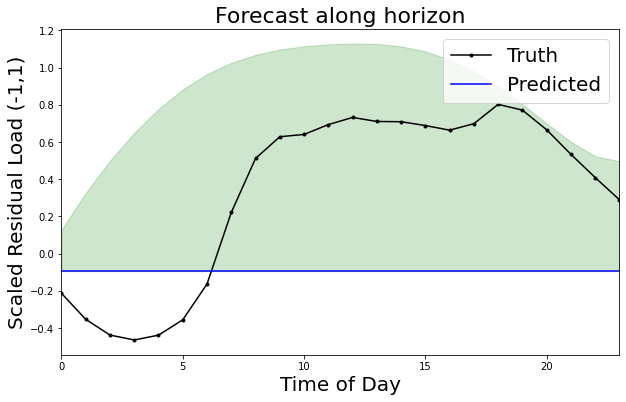

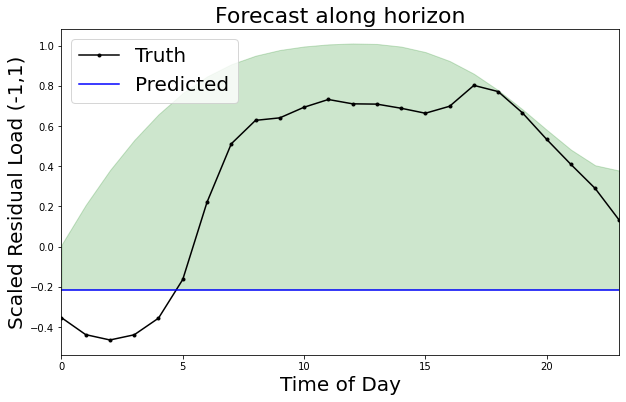

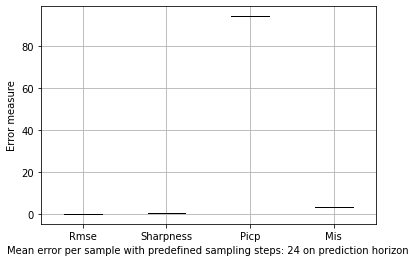

mean = array([[-0.029843  ,  0.11993426,  0.15911941, ..., -0.029843  ,
         0.11993426,  0.15911941],
       [ 0.11993426,  0.15911941,  0.09666537, ...,  0.11993426,
         0.15911941,  0.09666537],
       [ 0.15911941,  0.09666537, -0.00246529, ...,  0.15911941,
         0.09666537, -0.00246529],
       ...,
       [ 0.00125427,  0.16625579,  0.178885  , ...,  0.00125427,
         0.16625579,  0.178885  ],
       [ 0.16625579,  0.178885  ,  0.10808356, ...,  0.16625579,
         0.178885  ,  0.10808356],
       [ 0.178885  ,  0.10808356, -0.02028459, ...,  0.178885  ,
         0.10808356, -0.02028459]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

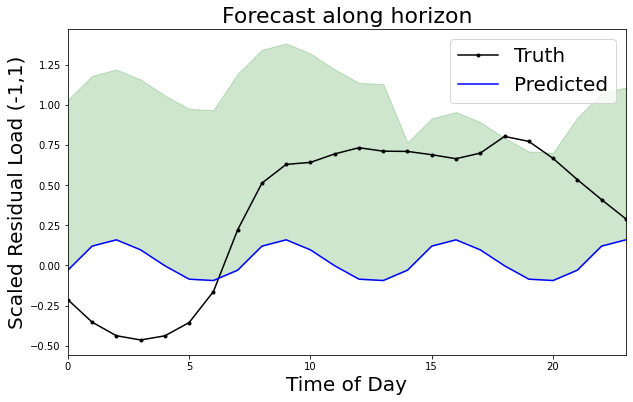

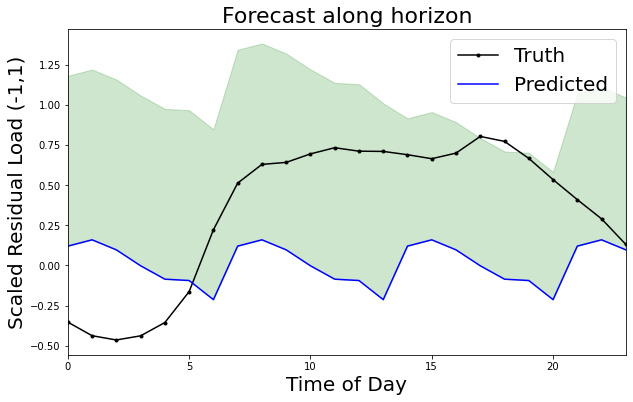

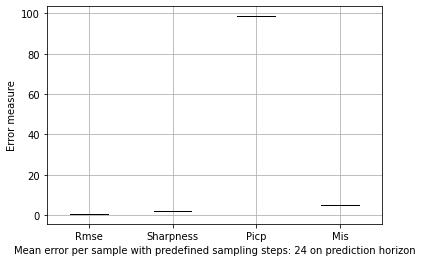

mean = array([[-0.1110271 , -0.1110271 , -0.1110271 , ..., -0.1110271 ,
        -0.1110271 , -0.1110271 ],
       [-0.24293038, -0.24293038, -0.24293038, ..., -0.24293038,
        -0.24293038, -0.24293038],
       [-0.37318659, -0.37318659, -0.37318659, ..., -0.37318659,
        -0.37318659, -0.37318659],
       ...,
       [-0.16906218, -0.16906218, -0.16906218, ..., -0.16906218,
        -0.16906218, -0.16906218],
       [-0.29269674, -0.29269674, -0.29269674, ..., -0.29269674,
        -0.29269674, -0.29269674],
       [-0.40111038, -0.40111038, -0.40111038, ..., -0.40111038,
        -0.40111038, -0.40111038]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

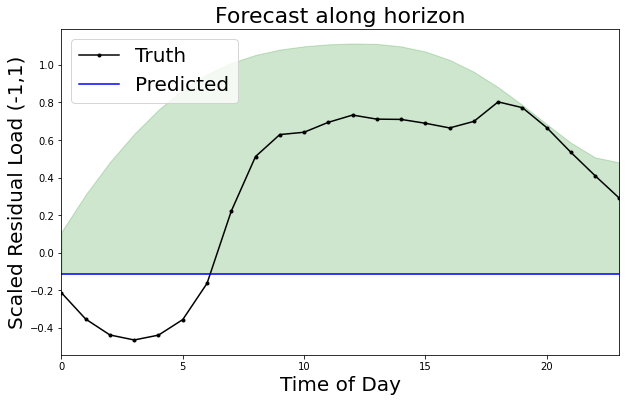

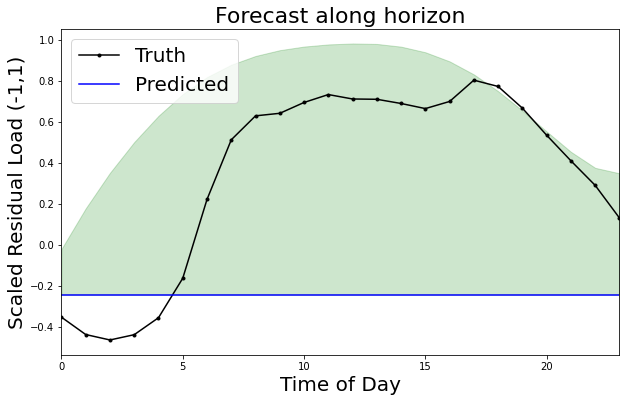

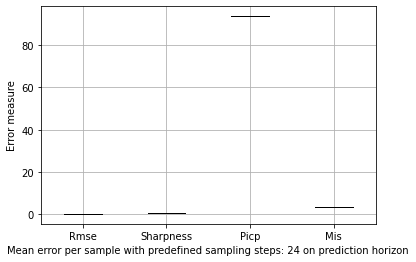

mean = array([[-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       ...,
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

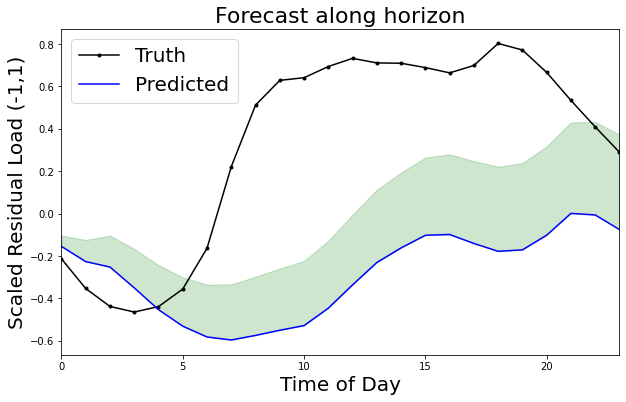

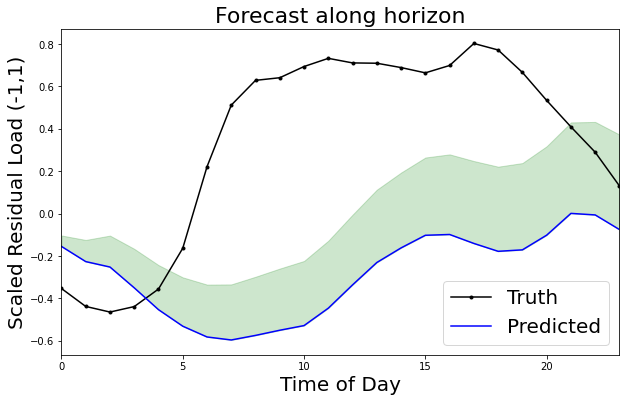

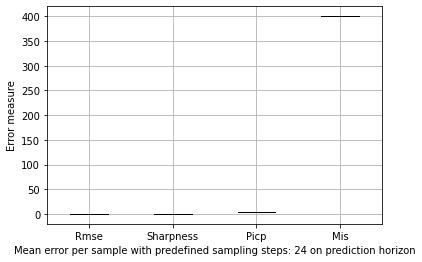

mean = array([[-0.19852438, -0.32406085, -0.41650805, ...,  0.09961801,
         0.06617319, -0.03762287],
       [-0.32406085, -0.41650805, -0.60775202, ...,  0.06617319,
        -0.03762287, -0.19851989],
       [-0.41650805, -0.60775202, -0.7862591 , ..., -0.03762287,
        -0.19851989, -0.32405726],
       ...,
       [-0.41650517, -0.60774971, -0.78625725, ..., -0.03762285,
        -0.19851987, -0.32405724],
       [-0.60774971, -0.78625725, -0.92028119, ..., -0.19851987,
        -0.32405724, -0.41650517],
       [-0.78625725, -0.92028119, -0.99468228, ..., -0.32405724,
        -0.41650517, -0.60774971]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

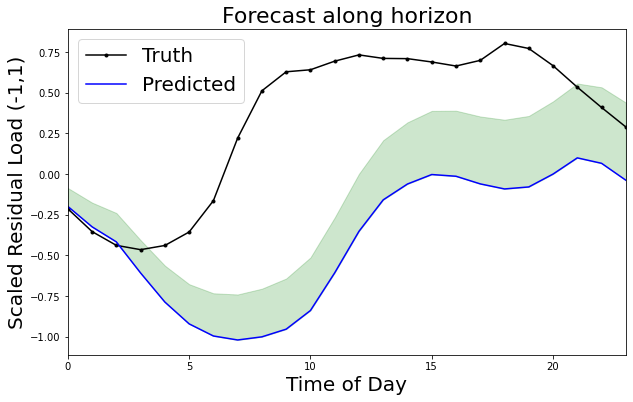

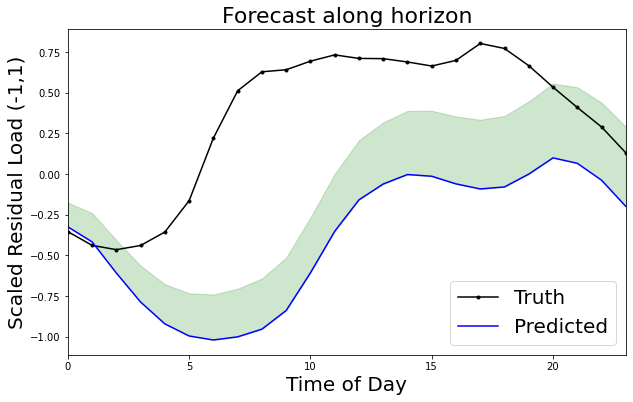

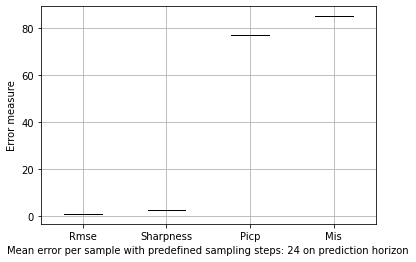

mean = array([[-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       ...,
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ],
       [-0.15475195, -0.22633838, -0.25201805, ...,  0.00099563,
        -0.00623889, -0.0752715 ]])
y_val_1D = array([[-0.21326932, -0.35327193, -0.43787032, ...,  0.5339302 ,
         0.40923837,  0.28960684],
       [-0.35327193, -0.43787032, -0.46438304, ...,  0.40923837,
         0.28960684,  0.13044418],
       [-0.43787032, -0.46438304, -0.4386056 , ...,  0.28960684,
         0.13044418, -0.02910774],
       ...,
       [-0.3047446 , -0.45024005, -0.53652525, ..., -0.29

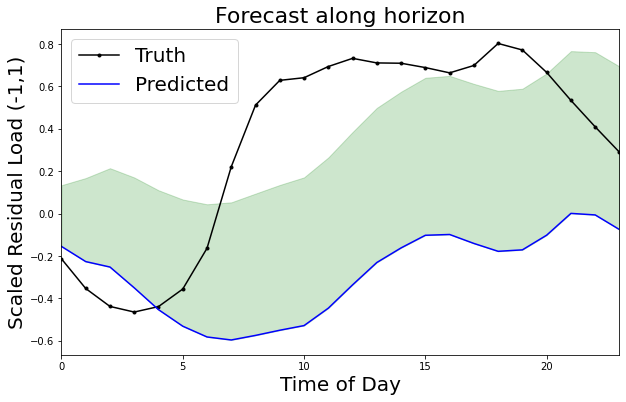

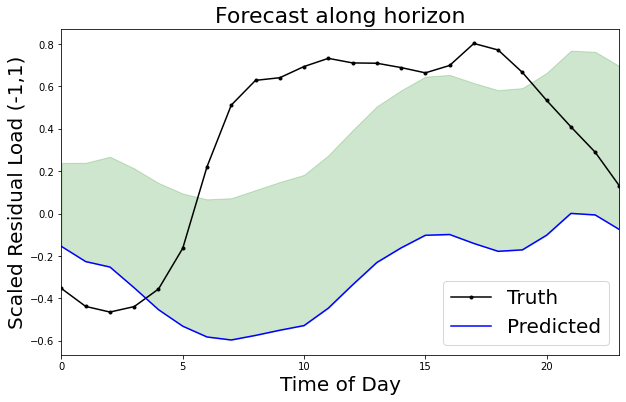

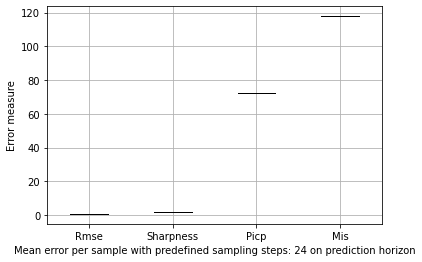

In [28]:
#==========================Evaluate ALL==========================
for i, mean in enumerate(mean_forecast):
    if mean is None:
        # skip if no mean prediciton
        continue
    print(f"{mean = }")
    print(f"{y_val_1D = }")
    if len(mean) - PAR["forecast_horizon"] == len(y_val_1D):
        (
            results[baseline_method[i]],
            results_per_timestep[baseline_method[i]],
            results_per_sample[i],
            true_values[i],
            forecasts[i],
            upper_limits[i],
            lower_limits[i],
        ) = baselines.eval_forecast(
            config=PAR,
            forecasts=mean[
                PAR["forecast_horizon"] : PAR["forecast_horizon"] + NUM_PRED
            ],
            endog_val=y_val_1D[:NUM_PRED, :],
            upper_limits=upper_PI[i][
                PAR["forecast_horizon"] : PAR["forecast_horizon"] + NUM_PRED, :
            ],
            lower_limits=lower_PI[i][
                PAR["forecast_horizon"] : PAR["forecast_horizon"] + NUM_PRED, :
            ],
            path=OUTDIR,
            model_name="test" + baseline_method[i],
            analyzed_metrics_avg=analyzed_metrics_avg,
            analyzed_metrics_sample=analyzed_metrics_sample,
            analyzed_metrics_timesteps=analyzed_metrics_ts,
        )
    else:
        (
            results[baseline_method[i]],
            results_per_timestep[baseline_method[i]],
            results_per_sample[i],
            true_values[i],
            forecasts[i],
            upper_limits[i],
            lower_limits[i],
        ) = baselines.eval_forecast(
            config=PAR,
            forecasts=mean[:NUM_PRED],
            endog_val=y_val_1D[:NUM_PRED, :],
            upper_limits=upper_PI[i][:NUM_PRED],
            lower_limits=lower_PI[i][:NUM_PRED],
            path=OUTDIR,
            model_name="test" + baseline_method[i],
            analyzed_metrics_avg=analyzed_metrics_avg,
            analyzed_metrics_sample=analyzed_metrics_sample,
            analyzed_metrics_timesteps=analyzed_metrics_ts,
        )

One issue with the above code is that the results per timestep per baseline, are as many values as predictions steps we have, evaluated for multiple metrics and multiple baseline methods. We now merge all the information into a multi-index, multi-column pandas dataframe for the plotting fuctions lateron

### Print Results Table

In [29]:
results_per_timestep_per_baseline = pd.concat(
    results_per_timestep.values(), keys=results_per_timestep.keys(), axis=1
)
results_per_sample = pd.concat(
    results_per_sample.values(), keys=results_per_timestep.keys(), axis=1
)
results_per_timestep_per_baseline.head()

simple-naive                                seasonal-naive            \
          Rmse Sharpness       Picp       Mis           Rmse Sharpness   
0     0.116450  0.444723  93.972603  3.575828       0.545522  2.119949   
1     0.219375  0.841612  93.698631  3.972717       0.546055  2.119903   
2     0.308221  1.188071  93.150688  4.319176       0.545668  2.119877   
3     0.384133  1.487641  93.150688  4.618746       0.544892  2.119875   
4     0.449433  1.743591  95.616440  4.874696       0.545065  2.119892   

                       naive-stl            ...    SARIMAX              \
        Picp       Mis      Rmse Sharpness  ...       Picp         Mis   
0  98.630135  4.737423  0.116362  0.444157  ...   4.931507  400.047805   
1  98.630135  4.737377  0.219037  0.840552  ...   7.671233  400.148876   
2  98.630135  4.737350  0.307950  1.187417  ...  11.506849  400.241135   
3  98.630135  4.737349  0.383834  1.487097  ...  10.410959  400.312499   
4  98.630135  4.737366  0.449061  1.743070  ...   6.027397  400.365266   

        ets                                     garch                       \
       Rmse Sharpness       Picp        Mis      Rmse Sharpness       Picp   
0  0.868896  2.487248  76.986298  85.134689  0.645621  1.714612  72.602737   
1  0.870240  2.496839  76.986298  85.144281  0.702762  1.726058  70.136986   
2  0.872261  2.506249  76.986298  85.153691  0.724142  1.725637  68.493149   
3  0.875730  2.515516  76.986298  85.162958  0.808471  1.719532  63.561646   
4  0.880411  2.524662  76.986298  85.172104  0.901407  1.710485  55.616440   

               
          Mis  
0  117.870989  
1  117.882436  
2  117.882014  
3  117.875909  
4  117.866862  

[5 rows x 24 columns]

In [30]:
results

,simple-naive,seasonal-naive,naive-stl,SARIMAX,ets,garch
Mse,0.254890,0.281842,0.254835,0.619954,0.779059,0.619954
Rmse,0.504866,0.530888,0.504812,0.787371,0.882643,0.787371
Sharpness,1.869416,2.032176,1.869109,0.611135,2.588866,1.645441
Picp,97.031960,97.739723,97.031960,24.623289,79.120995,60.559357
Rae,1.108838,1.201567,1.108760,1.858436,2.092518,1.858436
Mae,0.399938,0.433384,0.399910,0.670305,0.754735,0.670305
Mis,5.000521,4.649650,4.966085,400.555761,85.236308,117.801818
Mase,4.744855,4.968201,4.744691,7.758076,8.667648,7.758076
PinnballLoss,0.249966,0.270223,0.249909,0.767040,0.528180,0.497285
Residuals,0.016892,0.017889,0.016931,0.648521,0.753061,0.648521


### Plot the results

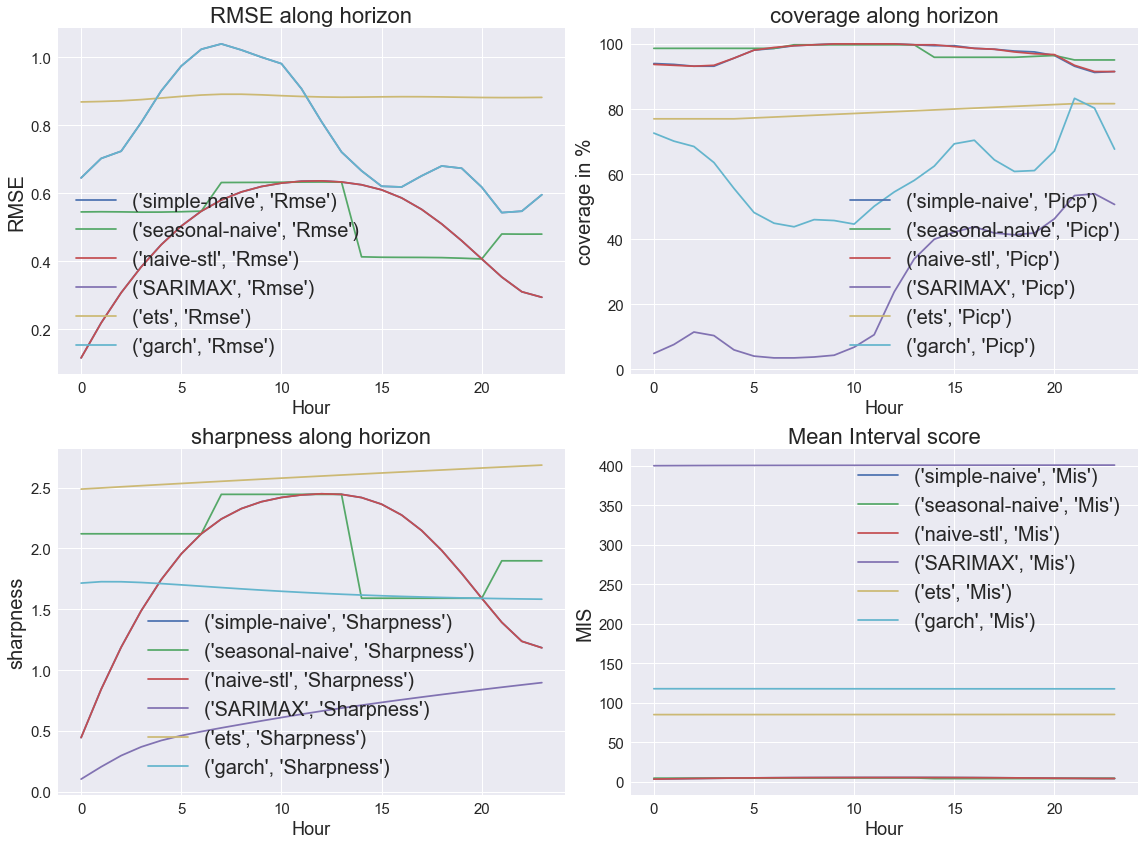

In [31]:
# plot metrics
# rmse_horizon, sharpness_horizon, coverage_horizon, mis_horizon, OUTPATH, title
plot.plot_metrics(
    results_per_timestep_per_baseline.xs(
        "Rmse", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Sharpness", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Picp", axis=1, level=1, drop_level=False
    ),
    results_per_timestep_per_baseline.xs(
        "Mis", axis=1, level=1, drop_level=False
    ),
    OUTDIR + "baselines",
)

We see that the best performing methods are on average, the Sarimax, Naive-STL, and seasonal naive. So we only go ahead and explore those ones in the next steps.

### Plot a historgramm of residuals

element = 'simple-naive'
element = 'seasonal-naive'
element = 'naive-stl'
element = 'SARIMAX'
element = 'ets'
element = 'garch'


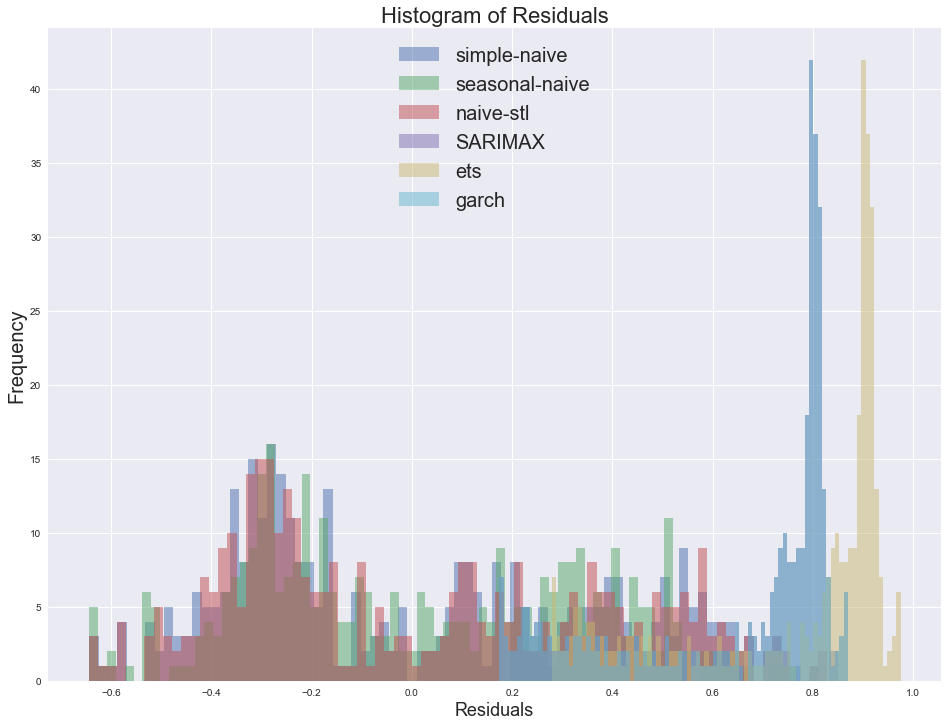

In [32]:
plot.plot_hist(
    data=results_per_sample.xs("Residuals", axis=1, level=1, drop_level=True),
    save_to=OUTDIR + "baselines",
    bins=80,
)

## Now let us fetch forecasts from an RNN trained model
The steps to prepare the data, train the model and generate predictions are all exlained in the example notebook on day-ahead prediction with ProLoaF applied on the open power system data.
There the results are pickled, which we will load here:

In [33]:
rnn_dataset_val = TimeSeriesData(
    df_val,
    history_horizon=PAR["history_horizon"],
    forecast_horizon=PAR["forecast_horizon"],
    encoder_features=PAR["encoder_features"],
    decoder_features=PAR["decoder_features"],
    target_id=PAR["target_id"],
)

In [34]:
import torch 

with torch.no_grad():
    ## LOAD RNN MODEL
    rnn_model = mh.ModelHandler.load_model(f"{INMODEL}.pkl", locate='cpu')
    rnn_model.to(DEVICE)
    
    dataloader = rnn_dataset_val.make_data_loader(batch_size=None, shuffle=False)
    logger.info(f"benchmarking {rnn_model.name}")
    inputs_enc, inputs_dec, targets = next(iter(dataloader))
    quantiles = rnn_model.loss_metric.get_quantile_prediction(
        predictions=rnn_model.predict(inputs_enc, inputs_dec),
        target=targets,
    )
    results_per_sample_RNN = mh.ModelHandler.benchmark(
    rnn_dataset_val,
    [rnn_model],
    test_metrics=analyzed_metrics_sample,
    avg_over="time",
)

2022-03-25 18:04:14 - tensorloader - DEBUG - frame not prepared
2022-03-25 18:04:14 - 93449077 - INFO - benchmarking opsd_recurrent


/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


2022-03-25 18:04:16 - tensorloader - DEBUG - tensor already prepared
2022-03-25 18:04:16 - modelhandler - INFO - benchmarking opsd_recurrent


In [35]:
RNN_targets = targets
RNN_forecasts = quantiles.get_mean().unsqueeze(dim=2)
RNN_upper_limits = quantiles.select_upper_bound().values
RNN_lower_limits = quantiles.select_lower_bound().values

In [36]:
#transpose to same dimensions:
baseline_targets_transposed = true_values.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_forecasts_transposed = forecasts.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_upper_limits_transposed = upper_limits.transpose(1,2)[:,:,:len(RNN_forecasts)]
baseline_lower_limits_transposed = lower_limits.transpose(1,2)[:,:,:len(RNN_forecasts)]

all_true_values = torch.cat((baseline_targets_transposed, RNN_targets[:NUM_PRED].transpose(0,2)),0).transpose(1,2)
all_forecasts = torch.cat((baseline_forecasts_transposed, RNN_forecasts[:NUM_PRED].transpose(0,2)),0).transpose(1,2)
all_upper_limits = torch.cat((baseline_upper_limits_transposed, RNN_upper_limits[:NUM_PRED].transpose(0,2)),0).transpose(1,2)
all_lower_limits = torch.cat((baseline_lower_limits_transposed, RNN_lower_limits[:NUM_PRED].transpose(0,2)),0).transpose(1,2)

In [37]:
all_methods = baseline_method
all_methods.append('RNN')

In [38]:
results_per_sample_RNN[:NUM_PRED]

opsd_recurrent                                                   \
               Mse      Rmse Sharpness   Picp       Rae         Mis   
0         0.005402  0.073501  0.455063  100.0  0.112660  966.680481   
1         0.004352  0.065968  0.461496  100.0  0.105388  966.680481   
2         0.004101  0.064037  0.487312  100.0  0.107390  966.680481   
3         0.004277  0.065402  0.496340  100.0  0.112679  966.680481   
4         0.004999  0.070704  0.509979  100.0  0.132561  966.680481   
..             ...       ...       ...    ...       ...         ...   
360       0.011358  0.106576  0.452898  100.0  0.197188  966.680481   
361       0.009045  0.095106  0.452415  100.0  0.173837  966.680481   
362       0.007536  0.086809  0.448915  100.0  0.154537  966.680481   
363       0.006357  0.079731  0.449057  100.0  0.136721  966.680481   
364       0.005778  0.076016  0.450459  100.0  0.130911  966.680481   

                            
    PinnballLoss Residuals  
0       0.039805  0.056537  
1       0.037647  0.044272  
2       0.038063  0.035546  
3       0.038804  0.044770  
4       0.042903  0.056398  
..           ...       ...  
360     0.063554  0.104463  
361     0.057460  0.092300  
362     0.052430  0.082415  
363     0.047712  0.072878  
364     0.046055  0.068238  

[365 rows x 8 columns]

In [39]:
all_results_per_sample = results_per_sample.join(results_per_sample_RNN[:NUM_PRED])

element = 'simple-naive'
element = 'seasonal-naive'
element = 'naive-stl'
element = 'SARIMAX'
element = 'ets'
element = 'garch'
element = 'opsd_recurrent'


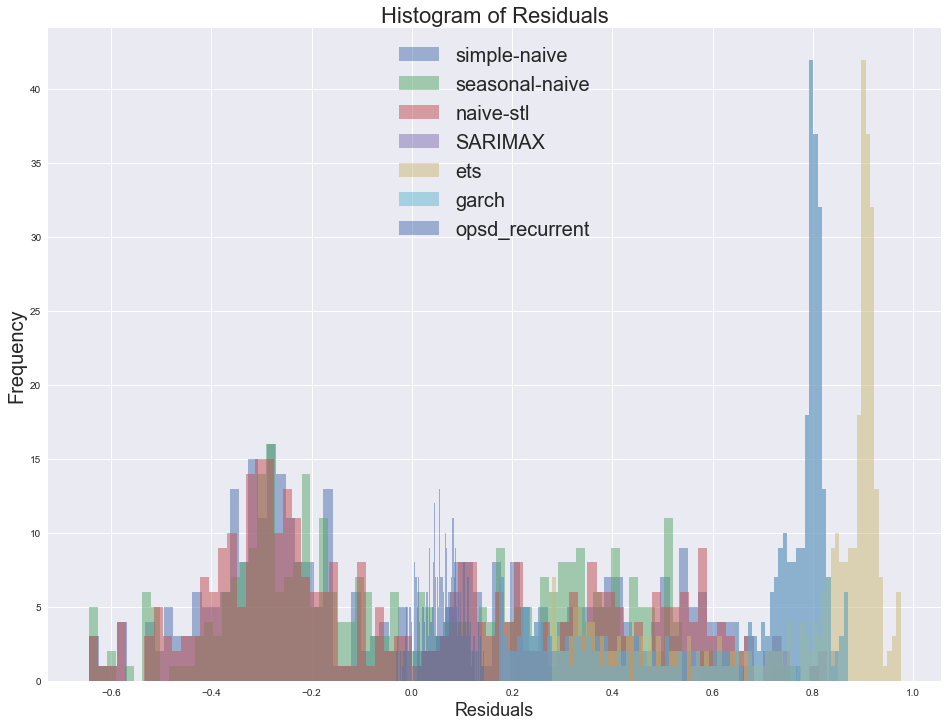

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13368.905611470947
            Iterations: 16
            Function evaluations: 102
            Gradient evaluations: 15
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13376.580774383456
            Iterations: 18
            Function evaluations: 111
            Gradient evaluations: 17
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13378.525081451
            Iterations: 18
            Function evaluations: 115
            Gradient evaluations: 17
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13373.86716128321
            Iterations: 16
            Function evaluations: 96
            Gradient evaluations: 16
Training and validat

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13368.832776010806
            Iterations: 19
            Function evaluations: 112
            Gradient evaluations: 19
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13378.258051120938
            Iterations: 21
            Function evaluations: 132
            Gradient evaluations: 19
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13376.268599546798
            Iterations: 16
            Function evaluations: 96
            Gradient evaluations: 15
Training and validating GARCH model completed.
Iteration:     20,   Func. Count:    126,   Neg. LLF: 13375.245981202075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13374.777316424681
            Iterations: 26
            Functi

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13369.31454578251
            Iterations: 17
            Function evaluations: 105
            Gradient evaluations: 16
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13374.597788054672
            Iterations: 19
            Function evaluations: 112
            Gradient evaluations: 17
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13378.650520404744
            Iterations: 19
            Function evaluations: 114
            Gradient evaluations: 17
Training and validating GARCH model completed.
Iteration:     20,   Func. Count:    131,   Neg. LLF: 114708.30247086109
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13374.06135257821
            Iterations: 22
            Functio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13370.777653881925
            Iterations: 19
            Function evaluations: 117
            Gradient evaluations: 17
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13378.770216754918
            Iterations: 17
            Function evaluations: 106
            Gradient evaluations: 16
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13377.986268383047
            Iterations: 19
            Function evaluations: 114
            Gradient evaluations: 18
Training and validating GARCH model completed.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13375.444048776666
            Iterations: 18
            Function evaluations: 112
            Gradient evaluations: 17
Training and va

In [40]:
with torch.no_grad():    
    plot.plot_hist(
        data=all_results_per_sample.xs("Residuals", axis=1, level=1, drop_level=True),
        save_to=OUTDIR + "baselines",
        bins=80,
    )